In [1]:
import pandas as pd 
import numpy as np

import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# My module built with Spotify API and spotipy library
from spotify import Spotify

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.io as pio


# My own credenctials
from utils.config import SpotifyCredectials

### Intialize Spotify API with artist Seaching Query

In [2]:
cred = SpotifyCredectials()

my_id = cred.my_id
my_secret = cred.my_secret

spotify = Spotify('Oasis', my_id, my_secret)

### Get data

In [3]:
# Get top 100 of Oasis audio feature data

n_top_tracks = 100

filtered_top_tracks_df = spotify.filter_by_popularity(n_top_tracks = n_top_tracks)
filtered_top_tracks_df.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,"Columbia (Live at Knebworth, 10 August '96)",0.275,0.806,2.0,-4.956,1.0,0.0442,0.000018,0.824,0.979,0.196,99.911,287722.0,4.0
1,"Acquiesce (Live at Knebworth, 10 August '96)",0.260,0.926,7.0,-4.668,1.0,0.0619,0.000009,0.884,0.982,0.253,124.697,236778.0,4.0
2,"Supersonic (Live at Knebworth, 10 August '96)",0.258,0.928,9.0,-4.918,1.0,0.0941,0.000049,0.489,0.985,0.422,122.963,309880.0,4.0
3,"Hello (Live at Knebworth, 11 August '96)",0.119,0.962,5.0,-4.118,1.0,0.0842,0.000018,0.589,0.856,0.150,149.610,175536.0,4.0
4,"Some Might Say (Live at Knebworth, 11 August '96)",0.168,0.869,2.0,-4.122,1.0,0.0736,0.000009,0.458,0.921,0.177,123.259,304629.0,4.0


### Apply PCA(Principle Component Analysis)

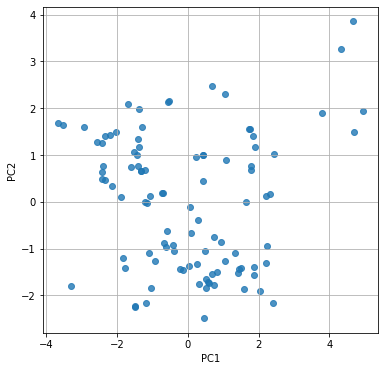

In [4]:
scaled_df_for_pca = spotify.standard_scaling(filtered_top_tracks_df[filtered_top_tracks_df.columns[1:]])

n_components = 2

pca = PCA(n_components=n_components)
pca.fit(scaled_df_for_pca)
feature = pca.transform(scaled_df_for_pca)
pca_df = pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(n_components)])


plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Observations<br>
<li>Variance in each PC looks relatively well distributed</li>

In [5]:
pd.DataFrame(pca.components_, columns=filtered_top_tracks_df.columns[1:], index=["PC{}".format(x + 1) for x in range(n_components)])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
PC1,0.432312,-0.395074,-0.06397,-0.144969,0.139835,-0.455339,0.315903,-0.320275,-0.325107,0.276032,-0.083347,-0.110098,-0.041225
PC2,-0.150726,-0.358505,-0.15227,-0.584047,-0.039534,-0.056262,0.219475,0.354276,0.439095,-0.099379,-0.297198,0.054165,-0.110040


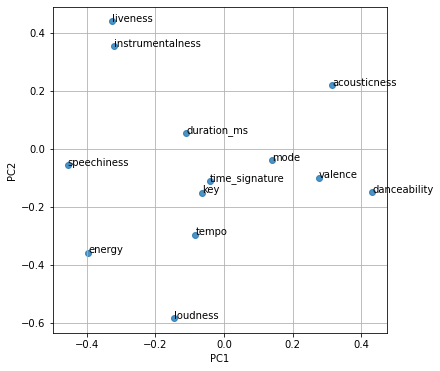

In [6]:
plt.figure(figsize=(6, 6))
for x, y, name in zip(pca.components_[0], pca.components_[1], filtered_top_tracks_df.columns[1:]):
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Observations<br>
<li>PC1- Highly contributed features [danceability > acousticness > valence > mode]</li>
PC1 is not quite clear characteristics, but it seems positive impression we might be able to feel from songs in that direction.<br><br> 
<li>PC2- Highly contributed features [liveness > instrumentalness > acousticness]</li>
PC2 is more likely to be live audio since 'liveness' is most contibuted feature followed by 'instrumentalness'<br><br> 

### Apply KMeans clustering model

In [7]:
model = KMeans(n_clusters=3, random_state=1)
model.fit(pca_df)
cluster = model.labels_
pca_df['cluster'] = cluster
pca_df.insert(0, 'name', filtered_top_tracks_df['name'])
pca_df.head()

,name,PC1,PC2,cluster
0,"Columbia (Live at Knebworth, 10 August '96)",-0.560811,2.139739,0
1,"Acquiesce (Live at Knebworth, 10 August '96)",-1.364584,1.172272,0
2,"Supersonic (Live at Knebworth, 10 August '96)",-1.318836,0.657562,0
3,"Hello (Live at Knebworth, 11 August '96)",-2.142437,0.343657,0
4,"Some Might Say (Live at Knebworth, 11 August '96)",-1.438043,0.999690,0


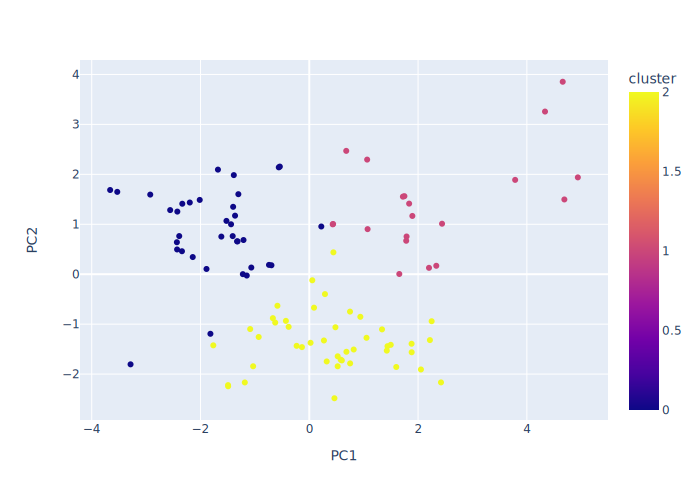

In [12]:
fig = px.scatter(pca_df, x="PC1", y="PC2", color='cluster')

fig = px.scatter(
    data_frame=pca_df, 
    x='PC1', 
    y='PC2', 
    color='cluster',
    custom_data=['name', 'cluster']
)

fig.update_traces(
    hovertemplate="<br>".join([
        "name: %{customdata[0]}",
        "cluster: %{customdata[1]}",
    ])
)

# fig.show()

# fig show for the github
fig.show(renderer="svg")

Observations<br>
<li>Cluster looks good. Let's see what kind of songs are assigned to each cluster</li>

#### See tracks in each cluster

In [9]:
pca_df[pca_df['cluster']==0]

,name,PC1,PC2,cluster
0,"Columbia (Live at Knebworth, 10 August '96)",-0.560811,2.139739,0
1,"Acquiesce (Live at Knebworth, 10 August '96)",-1.364584,1.172272,0
2,"Supersonic (Live at Knebworth, 10 August '96)",-1.318836,0.657562,0
3,"Hello (Live at Knebworth, 11 August '96)",-2.142437,0.343657,0
4,"Some Might Say (Live at Knebworth, 11 August '96)",-1.438043,0.999690,0
5,"Roll With It (Live at Knebworth, 11 August '96)",-2.557372,1.283883,0
6,"Slide Away (Live at Knebworth, 11 August '96)",-2.013864,1.487584,0
7,"Morning Glory (Live at Knebworth, 11 August '96)",-2.391011,0.763753,0
8,"Round Are Way (Live at Knebworth, 10 August '96)",-2.340696,0.459818,0
9,"Cigarettes & Alcohol (Live at Knebworth, 10 Au...",-1.148991,-0.026978,0


Observations<br>
<li>It is very obvious that most of tracks are live audio as we saw feature contribution in PC2</li>

In [10]:
pca_df[pca_df['cluster']==1]

,name,PC1,PC2,cluster
10,"Whatever (Live at Knebworth, 10 August '96)",1.721402,1.552745,1
11,"Cast No Shadow (Live at Knebworth, 10 August '96)",0.437959,1.005626,1
13,"The Masterplan (Live at Knebworth, 10 August '96)",1.064173,2.294977,1
22,Little By Little,2.335112,0.168774,1
26,Half The World Away,4.334106,3.256948,1
27,(Get Off Your) High Horse Lady,1.895167,1.166507,1
33,"Cast No Shadow - Live at Knebworth, 10 August '96",0.430528,0.998603,1
36,Champagne Supernova - Remastered,1.782052,0.669812,1
47,Go Let It Out,1.655078,0.004424,1
53,I'm Outta Time,1.835857,1.413297,1


Observations<br>
<li>This cluster have a few live audio. And what I have found is those songs are more like we can feel acoutstic ness such as 'Whatever', 'Wonderwall', 'The master plan'. So I think this cluster can be for songs which are mix of live audio and acousticness</li>

In [11]:
pca_df[pca_df['cluster']==2]

,name,PC1,PC2,cluster
20,Whatever - Remastered,0.481024,-1.062499,2
21,Stand By Me,0.522057,-1.843913,2
23,Roll with It,-1.491483,-2.244460,2
24,Stand by Me,0.751041,-1.785765,2
25,Waiting For The Rapture,1.438093,-1.441559,2
28,Acquiesce,-0.929972,-1.257113,2
30,Ain't Got Nothin',0.269576,-1.327162,2
31,All Around the World,0.055414,-0.121848,2
32,Bag It Up,0.938915,-0.853046,2
34,Champagne Supernova,0.749088,-0.749357,2


Observations<br>
<li>In this cluster, there is no live audio and it all consists of original audio. </li>